In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge
import torch
import pandas as pd
from lexical_diversity import lex_div as ld
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
import numpy as np
from scipy.spatial.distance import cosine

In [2]:
model_name = 'declare-lab/flan-alpaca-large'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.config.output_attentions = True

In [3]:
def get_response_and_scores(prompt, reference):

    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    input_ids = tokenizer.encode(response, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        
    loss = outputs.loss
    perplexity = torch.exp(loss)

    rouge = Rouge()
    scores = rouge.get_scores(response, reference)

    words = response.split()
    mtld_score = ld.mtld(words)

    response_length = len(response)

    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Recall': [scores[0]['rouge-1']['r'], scores[0]['rouge-2']['r'], scores[0]['rouge-l']['r']],
        'Precision': [scores[0]['rouge-1']['p'], scores[0]['rouge-2']['p'], scores[0]['rouge-l']['p']],
        'F1 Score': [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']],
    })

    print(f'ROUGE scores\n{df}')

    return response, perplexity.item(), scores, mtld_score, response_length

In [82]:
new_prompt = "Explain how transformer architectures work"

In [83]:
reference_text = "Sports, spanning from traditional games like football and tennis to emerging fields like eSports, involve strategic, psychological, nutritional, and physical aspects, and they play a significant role in international unity, technological advancement, scientific understanding, and personal development."
response, perplexity, rouge_scores, mtld, response_length = get_response_and_scores(new_prompt, reference_text)
print('\nResponse:', response)
print('Perplexity:', perplexity)
print('MTLD:', mtld)
print('Response length:', response_length)

ROUGE scores
    Metric    Recall  Precision  F1 Score
0  ROUGE-1  0.090909   0.111111       0.1
1  ROUGE-2  0.000000   0.000000       0.0
2  ROUGE-L  0.090909   0.111111       0.1

Response: Transformer architectures are a type of computer architecture that uses a transformer to convert a signal into a different type of signal. Transformers are typically used to convert signals from one type of signal to another, such as audio, video
Perplexity: 1.3856760263442993
MTLD: 40.0
Response length: 246


In [14]:
def visualize_attention(prompt, response):
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(f'Averaged Attention Map Flan-Alpaca (Baseline)')
    plt.colorbar(cax)
    plt.show()

In [84]:
response = response.split(".")[0] + "."

In [ ]:
visualize_attention(new_prompt, response)

In [173]:
def visualize_attention_per_head(prompt, response):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")

    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()

    num_heads = attention_weights.shape[0]
    

    grid_size = int(math.ceil(math.sqrt(num_heads)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.ravel()  

    for head in range(num_heads):
        cax = axs[head].matshow(attention_weights[head], cmap='viridis')
        
        src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
        
        axs[head].set_xticks(range(len(src_tokens)))
        axs[head].set_yticks(range(len(tgt_tokens)))
        axs[head].set_xticklabels(src_tokens, rotation=90, fontsize=6)
        axs[head].set_yticklabels(tgt_tokens, fontsize=6)
        axs[head].set_title(f'Flan-Alpaca Head {head+1} (RPP)')
        fig.colorbar(cax, ax=axs[head], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    fig.savefig('attention_heads_rpp_alpaca.png', dpi=300)

In [ ]:
visualize_attention_per_head(new_prompt, response)

In [175]:
def visualize_bar_attention_for_token(prompt, response, token_of_interest):
    
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Find index of the token of interest
    token_index = input_ids[0].tolist().index(tokenizer.encode(token_of_interest, add_special_tokens=False)[0])
    
    # Extract attention weights for the token of interest
    attention_for_token = attention_weights[:, token_index, :]
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_for_token, axis=0)
    
    # Tokens in the response
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    # Plot bar chart
    plt.figure(figsize=(12,6))
    plt.bar(tgt_tokens, attention_weights_avg)
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel('Attention Weight', fontsize=12)
    plt.title(f'Averaged Attention Weights for Token "{token_of_interest}"', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_bar_attention_for_token(new_prompt, response, "Imagine")

In [5]:
def visualize_encoder_self_attention(prompt):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Create dummy decoder input to satisfy the model's requirements
    dummy_decoder_input = torch.zeros_like(input_ids)
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=dummy_decoder_input, output_attentions=True)
    attention_weights = outputs.encoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    
    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels(src_tokens, fontsize=6)
    
    plt.title(f'Averaged Encoder Self-Attention Map')
    plt.colorbar(cax)
    plt.show()


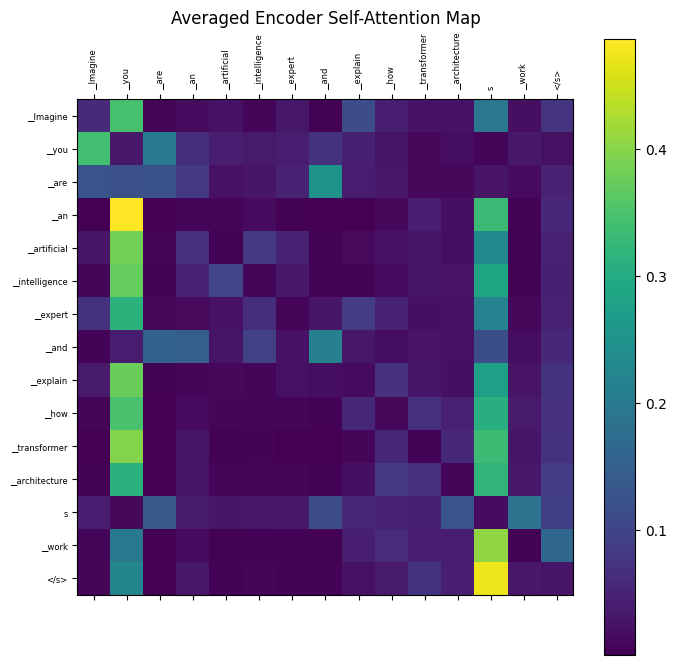

In [6]:
visualize_encoder_self_attention(new_prompt)

In [7]:
import math

def visualize_encoder_self_attention_per_head(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Create dummy decoder input to satisfy the model's requirements
    dummy_decoder_input = torch.zeros_like(input_ids)
    
    outputs = model(input_ids, decoder_input_ids=dummy_decoder_input, output_attentions=True)
    attention_weights = outputs.encoder_attentions[-1][0].squeeze().cpu().detach().numpy()

    num_heads = attention_weights.shape[0]
    
    grid_size = int(math.ceil(math.sqrt(num_heads)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.ravel()

    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    
    for head in range(num_heads):
        cax = axs[head].matshow(attention_weights[head], cmap='viridis')
        
        axs[head].set_xticks(range(len(src_tokens)))
        axs[head].set_yticks(range(len(src_tokens)))
        axs[head].set_xticklabels(src_tokens, rotation=90, fontsize=6)
        axs[head].set_yticklabels(src_tokens, fontsize=6)
        axs[head].set_title(f'Head {head+1} Encoder Self-Attention')
        fig.colorbar(cax, ax=axs[head], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    fig.savefig('encoder_self_attention_heads.png', dpi=300)

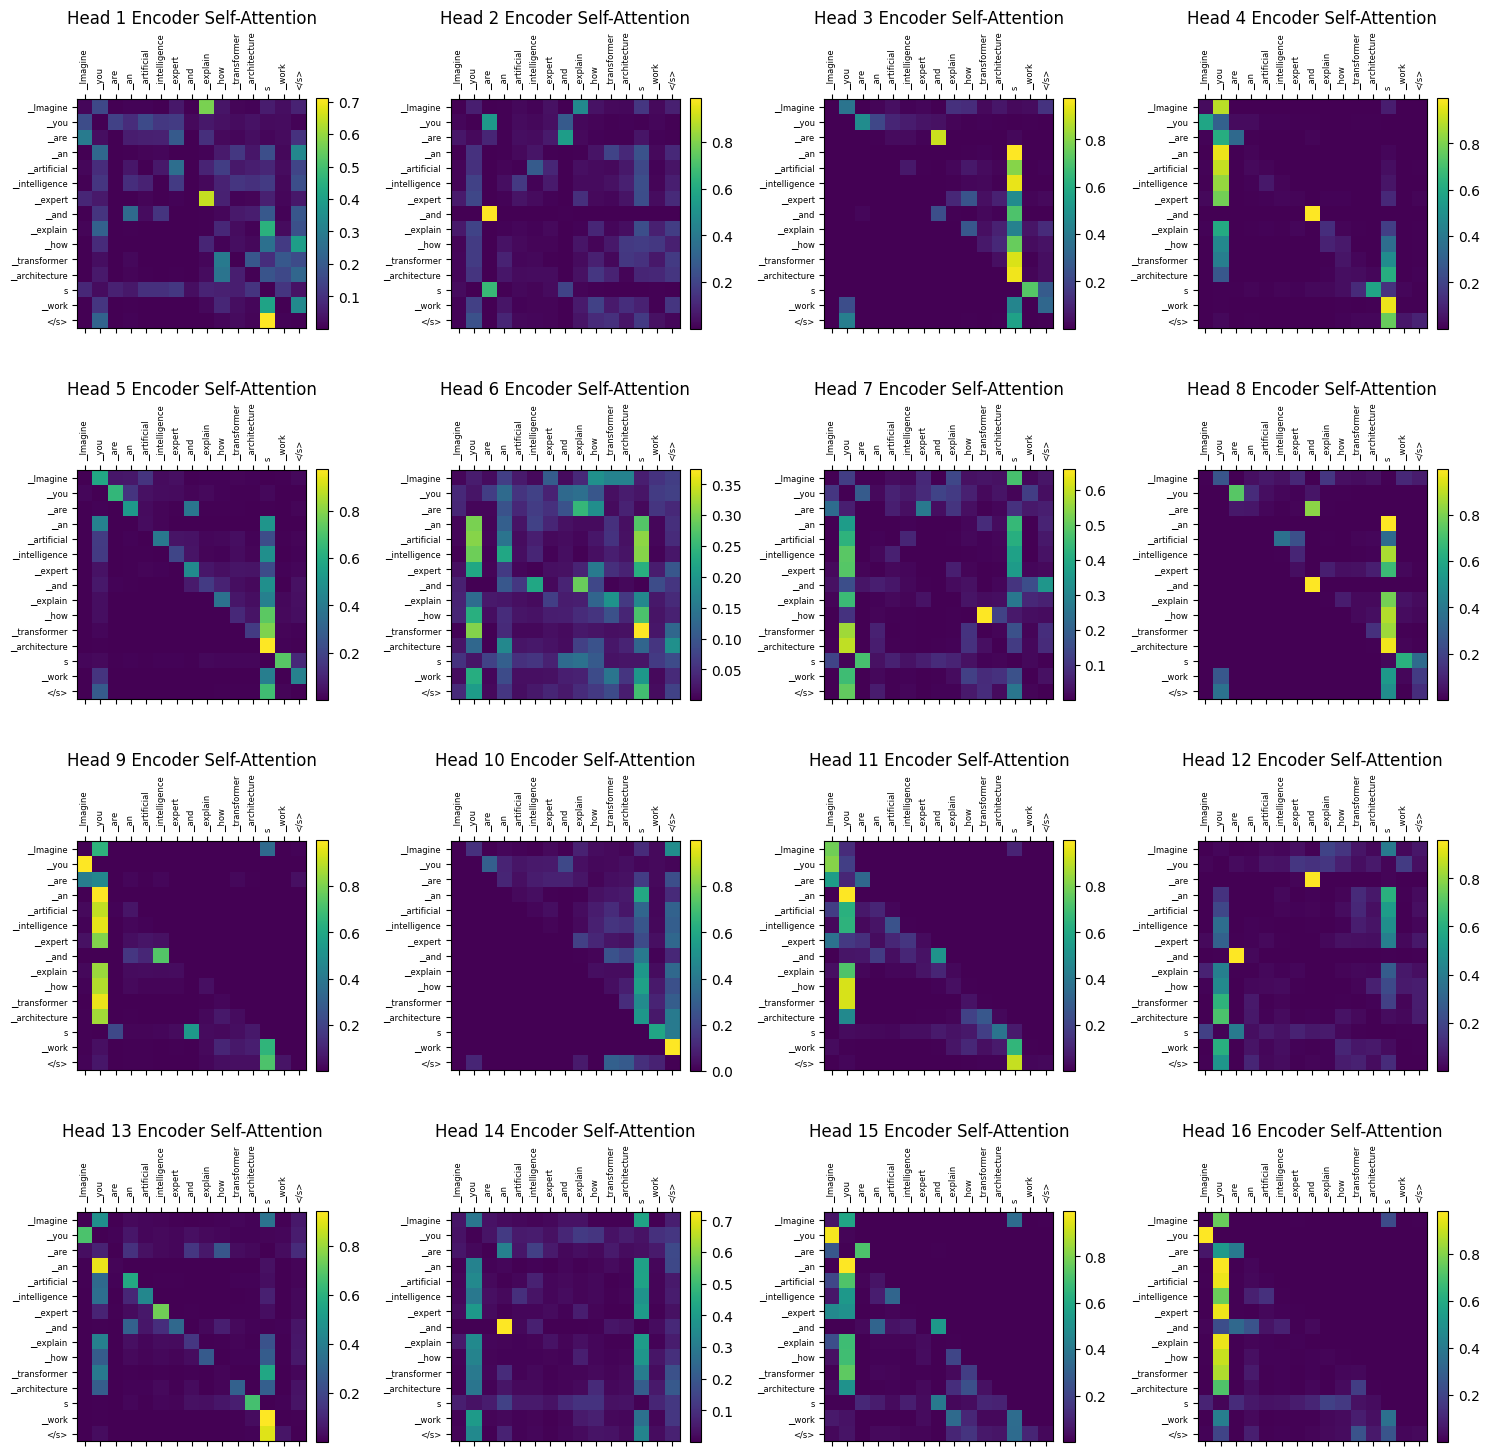

In [8]:
visualize_encoder_self_attention_per_head(new_prompt)

In [86]:
def calculate_entropy(p):
    p = p[p > 0]  # Filter zero probabilities to avoid log(0)
    return -np.sum(p * np.log(p))

def calculate_cosine_similarity(A, B):
    A_flat = A.flatten()
    B_flat = B.flatten()
    return 1 - cosine(A_flat, B_flat)

input_ids = tokenizer.encode(new_prompt, return_tensors="pt")
response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy() 
#[-1] index used to select the attention weights from the last decoder layer
#[0] index used to select the attention weights of all heads from that layer
normalized_attention_weights = attention_weights / attention_weights.sum(axis=1, keepdims=True)


In [87]:
# Calculate entropy for each token's attention distribution
entropies = [calculate_entropy(row) for row in normalized_attention_weights]
print(f"Entropies: {entropies}")

# Example: Calculate cosine similarity between attention distributions of the first and second tokens
similarity = calculate_cosine_similarity(normalized_attention_weights[0], normalized_attention_weights[1])
print(f"Cosine Similarity between Token 1 and Token 2: {similarity}")

Entropies: [30.80757, 30.747223, 34.910835, 33.746796, 30.191683, 42.594837, 23.846157, 46.296013, 44.807983, 50.556427, 54.675625, 33.160202, 32.391663, 29.775688, 43.250504, 47.027374]
Cosine Similarity between Token 1 and Token 2: 0.7591960430145264


In [129]:
entropies_rpp = [36.060104, 24.947308, 34.719234, 37.692123, 35.15366, 47.905056, 26.15507, 44.973984, 
             48.297813, 54.04659, 59.05487, 34.56177, 33.365955, 29.534101, 48.287033, 52.727825]

entropies_sip = [30.80757, 30.747223, 34.910835, 33.746796, 30.191683, 42.594837, 23.846157, 46.296013, 
                 44.807983, 50.556427, 54.675625, 33.160202, 32.391663, 29.775688, 43.250504, 47.027374]

def get_entropy_difference(rp_entropy, si_entropy):
    return [i - j for i, j in zip(rp_entropy, si_entropy)]

difs = get_entropy_difference(entropies, entropies_sip)
print(difs)

[-4.962158186572196e-07, -9.960937674691195e-08, 2.6611328252101885e-07, -3.45703128346031e-07, -1.8444824334551413e-07, 1.887207048412165e-07, 7.397460777269771e-08, -1.2158203333001438e-07, 3.9843749988222044e-07, 1.953125661202648e-09, -1.5258788721439487e-07, 2.6367189320808393e-08, -4.0234375120462573e-07, 1.7138671992711352e-07, -4.599609368938218e-07, 2.6757812321420715e-07]


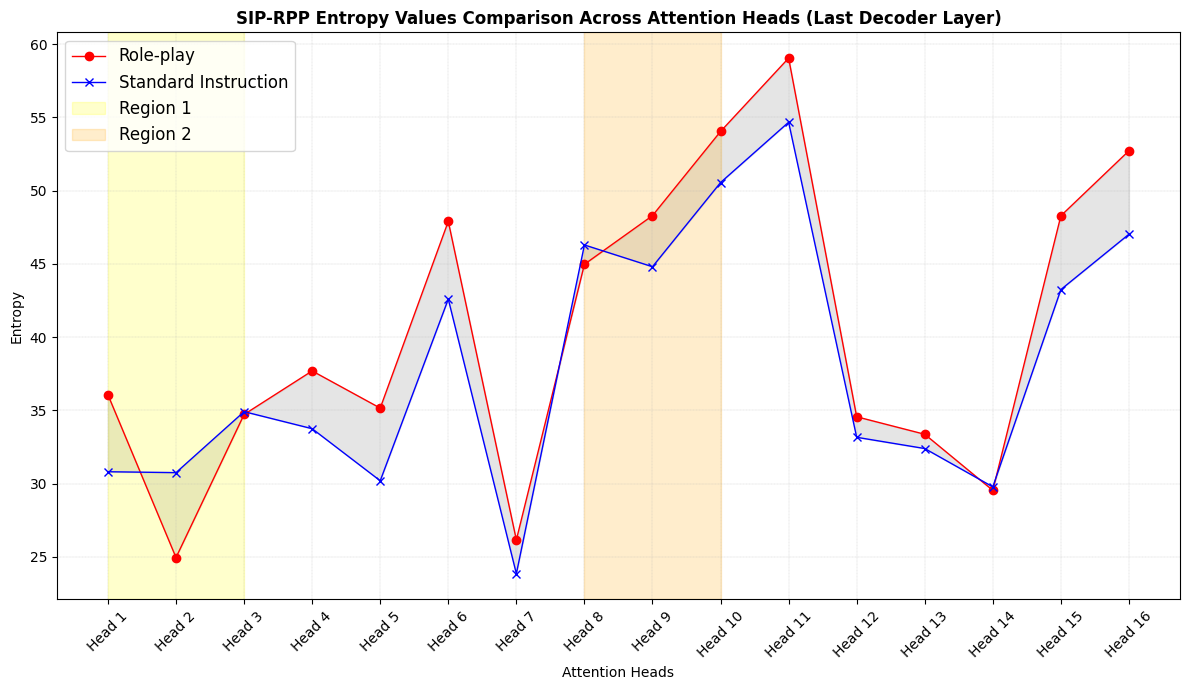

In [151]:
fig, ax = plt.subplots(figsize=(12, 7))

plt.fill_between(range(len(entropies_rpp)), entropies_rpp, entropies_sip, color='gray', alpha=0.2)

plt.plot(entropies_rpp, marker='o', linestyle='-', color='red', label='Role-play', linewidth=1)
plt.plot(entropies_sip, marker='x', linestyle='-', color='blue', label='Standard Instruction', linewidth=1)
plt.axvspan(0, 2, color='yellow', alpha=0.2, label='Region 1')
plt.axvspan(7, 9, color='orange', alpha=0.2, label='Region 2')

plt.xlabel('Attention Heads')
plt.ylabel('Entropy')
plt.title('SIP-RPP Entropy Values Comparison Across Attention Heads (Last Decoder Layer)', fontsize=12, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(fontsize=12, loc='upper left')
plt.xticks(ticks=range(len(entropies)), labels=[f"Head {i+1}" for i in range(len(entropies))], rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

fig.savefig('entropy_values_comparison.png', dpi=300)